<a href="https://colab.research.google.com/github/Arup3201/Image-Classification-Tensorflow/blob/main/image-classification-tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path

import numpy as np
import PIL
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Download and explore Dataset

In [2]:
# Import the kaggle.json file then run this cell
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tongpython/cat-and-dog

 91% 198M/218M [00:01<00:00, 142MB/s]
100% 218M/218M [00:01<00:00, 162MB/s]


In [3]:
!mkdir ./cats-dogs
!unzip -q cat-and-dog.zip -d ./cats-dogs
!rm cat-and-dog.zip

In [4]:
data_dir = Path('./cats-dogs')
training_dir = data_dir / 'training_set/training_set'
test_dir = data_dir / 'test_set/test_set'

In [5]:
train_image_count = len(list(training_dir.glob("*/*.jpg")))
test_image_count = len(list(test_dir.glob("*/*.jpg")))

In [6]:
print(f"Training images available: {train_image_count}")
print(f"Test images available: {test_image_count}")

Training images available: 8005
Test images available: 2023


In [7]:
cats = list(training_dir.glob("cats/*.jpg"))
dogs = list(training_dir.glob("dogs/*.jpg"))

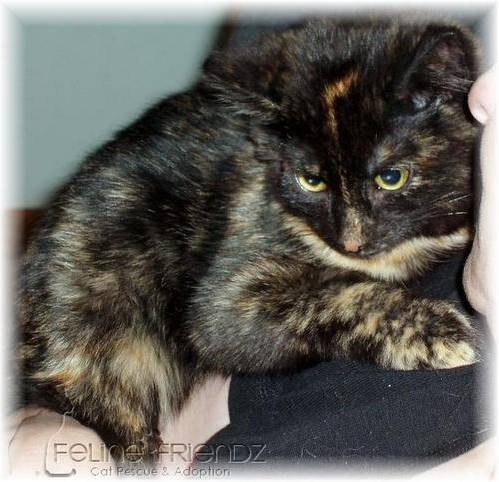

In [8]:
PIL.Image.open(str(cats[0]))

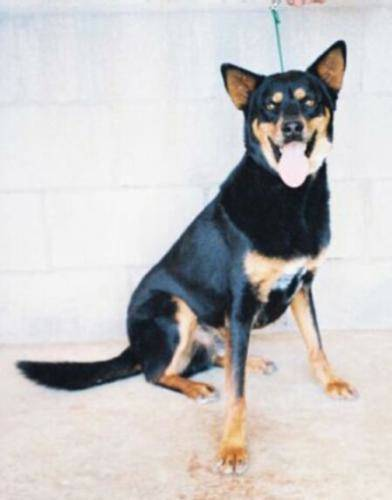

In [9]:
PIL.Image.open(str(dogs[0]))

Load dataset using keras utility function

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = keras.utils.image_dataset_from_directory(
    training_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 8005 files belonging to 2 classes.
Using 6404 files for training.
Found 2023 files belonging to 2 classes.
Using 404 files for validation.


In [12]:
class_names = train_ds.class_names
print(f"Available classes in the dataset: {class_names}")

Available classes in the dataset: ['cats', 'dogs']


Visualize the data

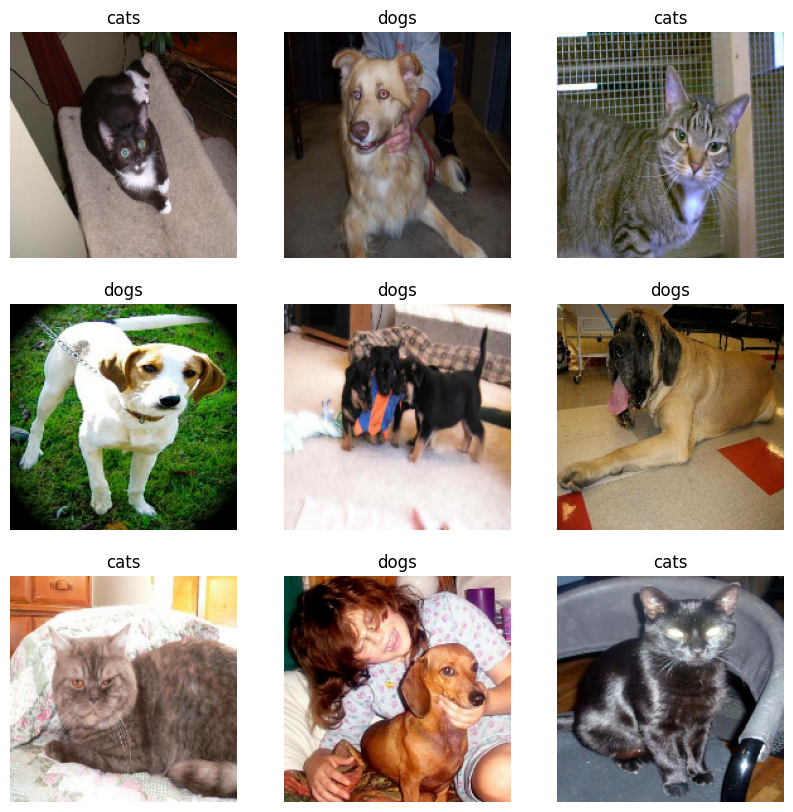

In [13]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Keras model

In [16]:
num_classes = len(class_names)
print(f"Number of classes avialable: {num_classes}")

Number of classes avialable: 2


In [17]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Train the model

In [20]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
201/201 [==============================] - 17s 26ms/step - loss: 0.6752 - accuracy: 0.5807 - val_loss: 0.6164 - val_accuracy: 0.6460
Epoch 2/15
201/201 [==============================] - 4s 18ms/step - loss: 0.5667 - accuracy: 0.7080 - val_loss: 0.5466 - val_accuracy: 0.7302
Epoch 3/15
201/201 [==============================] - 4s 18ms/step - loss: 0.4883 - accuracy: 0.7605 - val_loss: 0.5384 - val_accuracy: 0.7005
Epoch 4/15
201/201 [==============================] - 4s 19ms/step - loss: 0.4157 - accuracy: 0.8022 - val_loss: 0.5358 - val_accuracy: 0.7104
Epoch 5/15
201/201 [==============================] - 4s 18ms/step - loss: 0.3511 - accuracy: 0.8410 - val_loss: 0.4935 - val_accuracy: 0.7475
Epoch 6/15
201/201 [==============================] - 4s 18ms/step - loss: 0.2662 - accuracy: 0.8873 - val_loss: 0.5792 - val_accuracy: 0.7426
Epoch 7/15
201/201 [==============================] - 4s 19ms/step - loss: 0.1746 - accuracy: 0.9286 - val_loss: 0.6627 - val_accuracy: 0.725

Visualization of the model performance

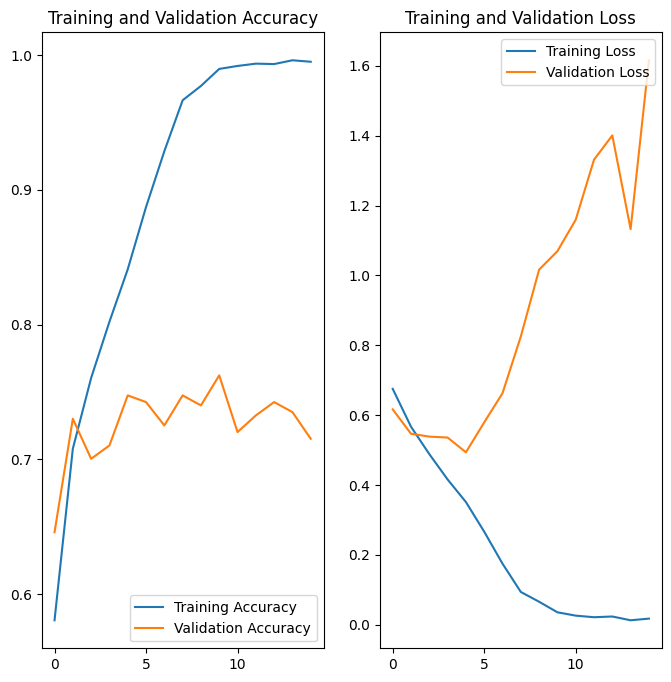

In [22]:
plt.figure(figsize=(8, 8))
epochs_range = list(range(epochs))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


ax = plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

loss = history.history['loss']
val_loss = history.history['val_loss']

ax = plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()

The model is overfitting on the dataset as the validation accuracy has stopped growing after 75%. Also, the validation loss has started increasing rapidly.

One of the techniques to improve the model performance and increase the model accuracy is to employe data augmentation and adding dropout layer to the model.

Data Augmentation

In [23]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

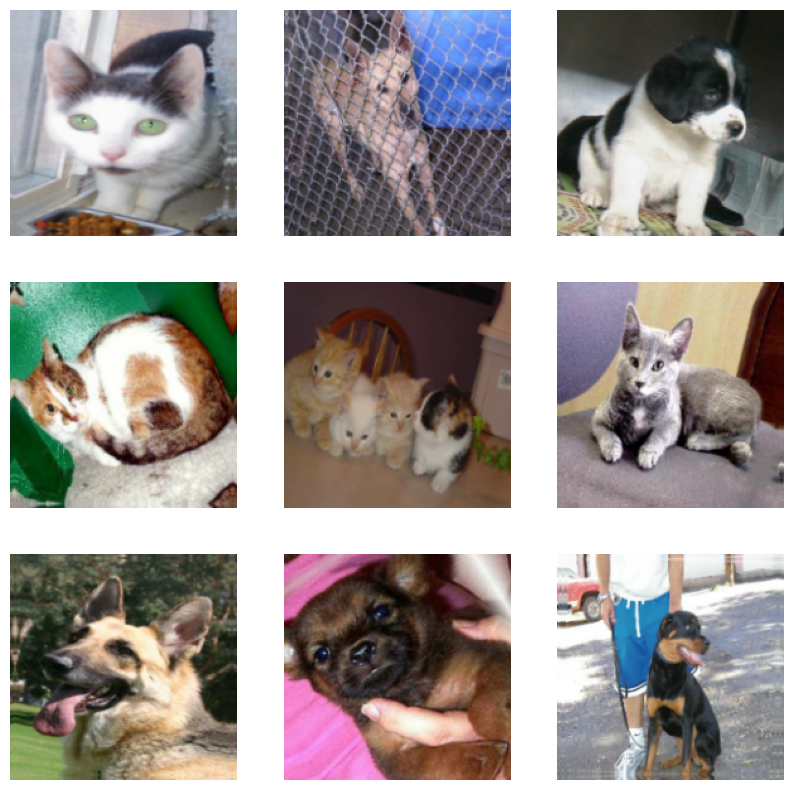

In [24]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  augmented_images = data_augmentation(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

In [35]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [36]:
model.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [38]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
201/201 [==============================] - 8s 29ms/step - loss: 0.6991 - accuracy: 0.5578 - val_loss: 0.6787 - val_accuracy: 0.5767
Epoch 2/15
201/201 [==============================] - 5s 26ms/step - loss: 0.6375 - accuracy: 0.6391 - val_loss: 0.6653 - val_accuracy: 0.6238
Epoch 3/15
201/201 [==============================] - 5s 27ms/step - loss: 0.5995 - accuracy: 0.6754 - val_loss: 0.5974 - val_accuracy: 0.6807
Epoch 4/15
201/201 [==============================] - 5s 27ms/step - loss: 0.5733 - accuracy: 0.7017 - val_loss: 0.5915 - val_accuracy: 0.6955
Epoch 5/15
201/201 [==============================] - 5s 27ms/step - loss: 0.5420 - accuracy: 0.7228 - val_loss: 0.5420 - val_accuracy: 0.7030
Epoch 6/15
201/201 [==============================] - 5s 27ms/step - loss: 0.5327 - accuracy: 0.7378 - val_loss: 0.5437 - val_accuracy: 0.7054
Epoch 7/15
201/201 [==============================] - 5s 27ms/step - loss: 0.5141 - accuracy: 0.7464 - val_loss: 0.5692 - val_accuracy: 0.7252

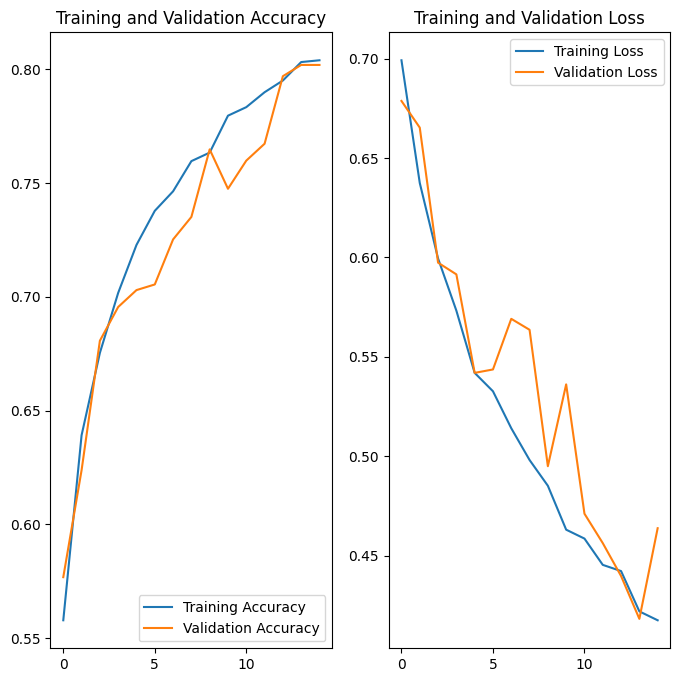

In [39]:
plt.figure(figsize=(8, 8))
epochs_range = list(range(epochs))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


ax = plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

loss = history.history['loss']
val_loss = history.history['val_loss']

ax = plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()